In [76]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import tensorflow.keras.backend as kb
import ml_util_4_head

import time
from scipy import signal
import importlib
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError


In [109]:
#Experiment_options
importlib.reload(ml_util_4_head)
window_size = 80
# num_snapshots_in_sequence = 128
num_snapshots_in_sequence = 256

# use_smooth = False
use_smooth = False
do_filter = False
predict_future_by = 0 # num samples to predict into the future

use_side_flag = False
subjects_to_train_with = [1,2,3,4,5,6,7,8,9]

# b, a = signal.butter(Wn=0.1, N=1)

sides = ['LEFT', 'RIGHT']
# sides = ['LEFT']

trial_nums = 1+np.arange(11)
print('trials to train with: ', trial_nums, 'subjects to train with: ', subjects_to_train_with)

root_folder = "unilateral_4_head"
print(root_folder)
sequence_len = num_snapshots_in_sequence + window_size - 1
training_instances = np.empty(shape=[0,sequence_len, 12], dtype=np.float32)
files_to_train_with = ml_util_4_head.get_files_to_use(root_folder, subjects_to_train_with, sides, trial_nums)
print(files_to_train_with)

trials to train with:  [ 1  2  3  4  5  6  7  8  9 10 11] subjects to train with:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
unilateral_4_head
['unilateral_4_head\\S01\\20230419_1055_S01_T01_LEFT.csv', 'unilateral_4_head\\S01\\20230419_1104_S01_T02_LEFT.csv', 'unilateral_4_head\\S01\\20230419_1047_S01_T03_LEFT.csv', 'unilateral_4_head\\S01\\20230419_0932_S01_T04_LEFT.csv', 'unilateral_4_head\\S01\\20230419_0947_S01_T05_LEFT.csv', 'unilateral_4_head\\S01\\20230419_1042_S01_T07_LEFT.csv', 'unilateral_4_head\\S01\\20230419_1055_S01_T01_RIGHT.csv', 'unilateral_4_head\\S01\\20230419_1104_S01_T02_RIGHT.csv', 'unilateral_4_head\\S01\\20230419_1047_S01_T03_RIGHT.csv', 'unilateral_4_head\\S01\\20230419_0932_S01_T04_RIGHT.csv', 'unilateral_4_head\\S01\\20230419_0947_S01_T05_RIGHT.csv', 'unilateral_4_head\\S01\\20230419_1042_S01_T07_RIGHT.csv', 'unilateral_4_head\\S02\\20230425_1543_S02_T01_LEFT.csv', 'unilateral_4_head\\S02\\20230425_1552_S02_T02_LEFT.csv', 'unilateral_4_head\\S02\\20230425_1609_S02_T04_LEFT.

In [113]:
for myfile in files_to_train_with:
    data = ml_util_4_head.load_file(myfile)

    ss_col = data[:,-4]
    ss_col[ss_col==0]=-1
    data[:,-4] = ss_col

    num_rows, num_cols = data.shape

    num_rows_to_drop = num_rows % sequence_len

    data = data[0:-num_rows_to_drop]
    new_num_rows, num_cols = data.shape
    num_sequences = new_num_rows/sequence_len
    new_data_shape = (int(num_sequences), sequence_len, num_cols)
    new_instances = data.reshape(new_data_shape)

    training_instances = np.append(training_instances, new_instances, axis=0)



shuffled_training_instances = tf.random.shuffle(training_instances) 
num_channels = 8
x = shuffled_training_instances[:, :, :num_channels]
y_v = shuffled_training_instances[:, window_size-1:,-3]
y_r = shuffled_training_instances[:, window_size-1:,-4]
y_sp = shuffled_training_instances[:, window_size-1:,-1]
y_ss = shuffled_training_instances[:, window_size-1:,-2]

print(y_v[:5])
print(y_r[:5])
print(y_sp[:5])
print(y_ss[:5])
split_fraction = 0.8
split_num = int(np.rint(split_fraction*x.shape[0]))
x_train = x[:split_num,:,:]
x_train = tf.cast(x_train, tf.float32)
y_sp_train = y_sp[:split_num,:]
y_ss_train = y_ss[:split_num,:]
y_r_train = y_r[:split_num,:]
y_v_train = y_v[:split_num,:]

x_valid = x[split_num:,:,:]
y_sp_valid = y_sp[split_num:,:]
y_ss_valid = y_ss[split_num:,:]
y_r_valid = y_r[split_num:,:]
y_v_valid = y_v[split_num:,:]


print('shape of x_train: ', x_train.shape, 'shape of y_sp_train: ', y_sp_train.shape, 'shape of y_ss_train: ', y_ss_train.shape,
'\nshape of x_valid: ', x_valid.shape, 'shape of y_sp_valid: ', y_sp_valid.shape, 'shape of y_ss_valid: ', y_ss_valid.shape)
print(x_train.dtype)

plt.plot(np.transpose(y_v_valid))
plt.show()

v:  [1. 1. 1. ... 0. 0. 0.]
r:  [0. 0. 0. ... 0. 0. 0.]
sp:  [-1. -1. -1. ... -1. -1. -1.]
ss:  [10. 10. 10. ... 10. 10. 10.]
v:  [1. 1. 1. ... 1. 1. 1.]
r:  [0.         0.         0.         ... 0.9352518  0.94244604 0.94964029]
sp:  [-1. -1. -1. ... -1. -1. -1.]
ss:  [-10. -10. -10. ... -10. -10. -10.]
v:  [1. 1. 1. ... 1. 1. 1.]
r:  [0.         0.         0.         ... 0.84172662 0.84892086 0.85611511]
sp:  [-1. -1. -1. ... -1. -1. -1.]
ss:  [5. 5. 5. ... 5. 5. 5.]
v:  [1. 1. 1. ... 1. 1. 1.]
r:  [0.         0.         0.         ... 0.3492823  0.35406699 0.35885167]
sp:  [-1. -1. -1. ... -1. -1. -1.]
ss:  [0. 0. 0. ... 0. 0. 0.]
v:  [1. 1. 1. ... 0. 1. 1.]
r:  [0.        0.        0.        ... 0.        0.        0.0060241]
sp:  [-1. -1. -1. ... -1. -1. -1.]
ss:  [0. 0. 0. ... 0. 0. 0.]
v:  [1. 1. 1. ... 0. 0. 0.]
r:  [0. 0. 0. ... 0. 0. 0.]
sp:  [-1. -1. -1. ... -1. -1. -1.]
ss:  [-5. -5. -5. ... -5. -5. -5.]
v:  [1. 1. 1. ... 1. 1. 1.]
r:  [0.         0.         0.         ... 

KeyboardInterrupt: 

In [81]:
def construct_model_2023(window_size,
                         filter_sizes,
                         kernel_sizes,
                         dilations,
                         num_channels=8,
                         batch_norm_insertion_pts=[2],
                         sp_dense_sizes=[20, 10],
                         ss_dense_sizes=[20, 10],
                         v_dense_sizes=[20, 10],
                         r_dense_sizes=[20, 10],

                         do_fix_input_dim=False):
  if len(filter_sizes) != len(kernel_sizes)+1:
      raise ValueError(
          'Must provide one more filter size than kernel size--last kernel size is calculated')
  current_output_size = window_size  # Track for final conv layer

  #Use None in dim 0 to allow variable input length.
  #Use window_size to fix size--helpful for debugging dimensions
  if do_fix_input_dim:
    input_layer = tf.keras.layers.Input(
        shape=(window_size, num_channels), name='my_input_layer')
  else:
    input_layer = tf.keras.layers.Input(
        shape=(None, num_channels), name='my_input_layer')

  z = input_layer
  for layer_idx in range(len(kernel_sizes)):
      z = tf.keras.layers.Conv1D(filters=filter_sizes[layer_idx], kernel_size=kernel_sizes[layer_idx],
                                  dilation_rate=dilations[layer_idx], activation='relu')(z)
      if layer_idx in batch_norm_insertion_pts:
          z = tf.keras.layers.BatchNormalization()(z)
      current_output_size = current_output_size - \
          dilations[layer_idx]*kernel_sizes[layer_idx] + dilations[layer_idx]
  if current_output_size < 1:
      raise ValueError('layers shrink the cnn too much')
  else:
      print('adding final conv layer of kernel size: ', current_output_size)
      last_conv_layer = tf.keras.layers.Conv1D(
          filters=filter_sizes[-1], kernel_size=current_output_size, activation='relu')(z)

  # gait phase DNN
  z = last_conv_layer
  for num_neurons in sp_dense_sizes:
      z = tf.keras.layers.Dense(num_neurons, activation='relu')(z)
  output_stance_phase = tf.keras.layers.Dense(1, name='stance_phase_output')(z)

  z = last_conv_layer
  for num_neurons in ss_dense_sizes:
      z = tf.keras.layers.Dense(num_neurons, activation='relu')(z)
  output_stance_swing = tf.keras.layers.Dense(
      1, activation='sigmoid', name='stance_swing_output')(z)
  
  z = last_conv_layer
  for num_neurons in v_dense_sizes:
      z = tf.keras.layers.Dense(num_neurons, activation='relu')(z)
  velocity = tf.keras.layers.Dense(1, name='velocity_output')(z)

  z = last_conv_layer
  for num_neurons in r_dense_sizes:
      z = tf.keras.layers.Dense(num_neurons, activation='relu')(z)
  ramp = tf.keras.layers.Dense(1, name='ramp_output')(z)

  model = tf.keras.Model(inputs=[input_layer], outputs=[
      output_stance_phase, output_stance_swing, velocity, ramp])

  return model

In [92]:
def construct_model_Xavier(window_size,
                         filter_sizes,
                         kernel_sizes,
                         dilations,
                         num_channels=8,
                         batch_norm_insertion_pts=[2],
                         sp_dense_sizes=[20, 10],
                         ss_dense_sizes=[20, 10],
                         v_dense_sizes=[20, 10],
                         r_dense_sizes=[20, 10],
                         do_fix_input_dim=False):
    if len(filter_sizes) != len(kernel_sizes) + 1:
        raise ValueError(
            'Must provide one more filter size than kernel size--last kernel size is calculated')
    current_output_size = window_size  # Track for final conv layer

    # Use None in dim 0 to allow variable input length.
    # Use window_size to fix size--helpful for debugging dimensions
    if do_fix_input_dim:
        input_layer = tf.keras.layers.Input(
            shape=(window_size, num_channels), name='my_input_layer')
    else:
        input_layer = tf.keras.layers.Input(
            shape=(None, num_channels), name='my_input_layer')

    z = input_layer
    for layer_idx in range(len(kernel_sizes)):
        z = tf.keras.layers.Conv1D(filters=filter_sizes[layer_idx], 
                                   kernel_size=kernel_sizes[layer_idx],
                                   dilation_rate=dilations[layer_idx], 
                                   activation='relu',
                                   kernel_initializer=tf.keras.initializers.GlorotUniform())(z)
        if layer_idx in batch_norm_insertion_pts:
            z = tf.keras.layers.BatchNormalization()(z)
        current_output_size = current_output_size - \
            dilations[layer_idx] * kernel_sizes[layer_idx] + dilations[layer_idx]
    if current_output_size < 1:
        raise ValueError('layers shrink the cnn too much')
    else:
        print('adding final conv layer of kernel size: ', current_output_size)
        last_conv_layer = tf.keras.layers.Conv1D(
            filters=filter_sizes[-1], kernel_size=current_output_size, activation='relu',
            kernel_initializer=tf.keras.initializers.GlorotUniform())(z)

    # gait phase DNN
    z = last_conv_layer
    for num_neurons in sp_dense_sizes:
        z = tf.keras.layers.Dense(num_neurons, activation='relu',
                                  kernel_initializer=tf.keras.initializers.GlorotUniform())(z)
    output_stance_phase = tf.keras.layers.Dense(1, name='stance_phase_output',
                                                kernel_initializer=tf.keras.initializers.GlorotUniform())(z)

    z = last_conv_layer
    for num_neurons in ss_dense_sizes:
        z = tf.keras.layers.Dense(num_neurons, activation='relu',
                                  kernel_initializer=tf.keras.initializers.GlorotUniform())(z)
    output_stance_swing = tf.keras.layers.Dense(
        1, activation='sigmoid', name='stance_swing_output',
        kernel_initializer=tf.keras.initializers.GlorotUniform())(z)

    z = last_conv_layer
    for num_neurons in v_dense_sizes:
        z = tf.keras.layers.Dense(num_neurons, activation='relu',
                                  kernel_initializer=tf.keras.initializers.GlorotUniform())(z)
    velocity = tf.keras.layers.Dense(1, name='velocity_output',
                                     kernel_initializer=tf.keras.initializers.GlorotUniform())(z)

    z = last_conv_layer
    for num_neurons in r_dense_sizes:
        z = tf.keras.layers.Dense(num_neurons, activation='relu',
                                  kernel_initializer=tf.keras.initializers.GlorotUniform())(z)
    ramp = tf.keras.layers.Dense(1, name='ramp_output',
                                 kernel_initializer=tf.keras.initializers.GlorotUniform())(z)

    model = tf.keras.Model(inputs=[input_layer], outputs=[
        output_stance_phase, output_stance_swing, velocity, ramp])

    return model


In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import MeanAbsoluteError
import pandas as pd
import matplotlib.pyplot as plt
import ml_util_4_head
from ml_util_4_head import custom_loss

# Parameters
num_ensembles = 2
window_size = 80
num_channels = 8
do_fix_input_dim = False
threshold = 0.05

# Function to create and compile the model
def create_model(window_size, num_channels, do_fix_input_dim):
    tf.keras.backend.clear_session()
    model = construct_model_Xavier(window_size=window_size,
                                 filter_sizes=[30,30,30,30], 
                                 kernel_sizes=[20,20, 20], 
                                 dilations=[1,1,1], 
                                 num_channels=num_channels,
                                 batch_norm_insertion_pts=[0,1,2], 
                                 sp_dense_sizes=[20,20,20], 
                                 ss_dense_sizes=[20,20], 
                                 v_dense_sizes=[20,20], 
                                 r_dense_sizes=[20,20], 
                                 do_fix_input_dim=do_fix_input_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=[custom_loss, 'binary_crossentropy', custom_loss, MeanAbsoluteError() ], 
                  loss_weights=[0.8, 0.2, 0.1, 0.1], 
                  optimizer=optimizer)
    return model

# Training phase
# Create ensemble of models
models = [create_model(window_size, num_channels, do_fix_input_dim) for _ in range(num_ensembles)]

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint('og_test1.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train each model in the ensemble
for i, model in enumerate(models):
    print(f"Training model {i+1}/{num_ensembles}")
    history = model.fit(x=x_train, 
                        y=[y_sp_train, y_ss_train, y_v_train, y_r_train], 
                        batch_size=32, 
                        epochs=10, 
                        validation_data=(x_valid, [y_sp_valid, y_ss_valid, y_v_valid, y_r_valid]), 
                        callbacks=[es, mc], 
                        verbose=1)
    model.save_weights(f'ensemble_model_{i}.weights.h5')

trial_nums = np.array([1])

adding final conv layer of kernel size:  23
adding final conv layer of kernel size:  23
Training model 1/2
Epoch 1/10
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.4508
Epoch 1: val_loss improved from inf to 0.33617, saving model to og_test1.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - loss: 0.4504 - val_loss: 0.3362
Epoch 2/10
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2967
Epoch 2: val_loss improved from 0.33617 to 0.22706, saving model to og_test1.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.2965 - val_loss: 0.2271
Epoch 3/10
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2219
Epoch 3: val_loss improved from 0.22706 to 0.21624, saving model to og_test1.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.2218 - val_loss: 0.2162
Epoch 4/10
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1997
Epoch 4: val_loss improved from 0.21624 to 0.18087, saving model to og_test1.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.1997 - va

Fully_Processed_Dataset_with_all_the_4_variables
['Fully_Processed_Dataset_with_all_the_4_variables\\S10\\20230511_1144_S10_T01_LEFT.csv']
adding final conv layer of kernel size:  23


c:\Users\ft700\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


adding final conv layer of kernel size:  23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


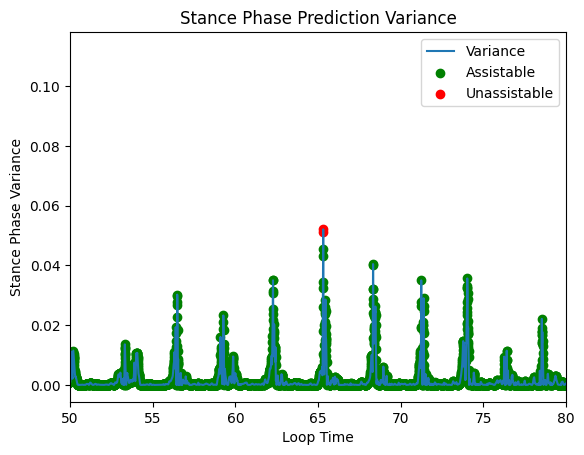

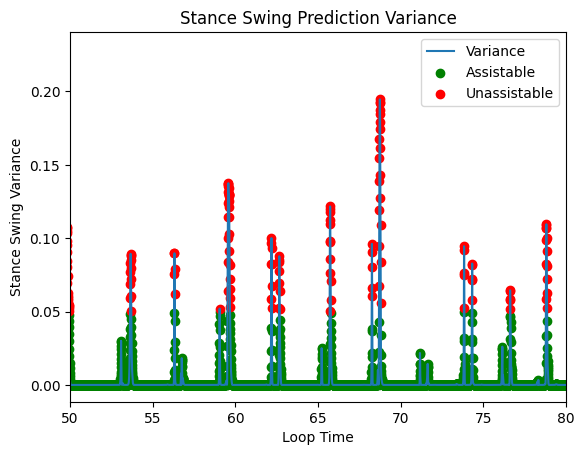

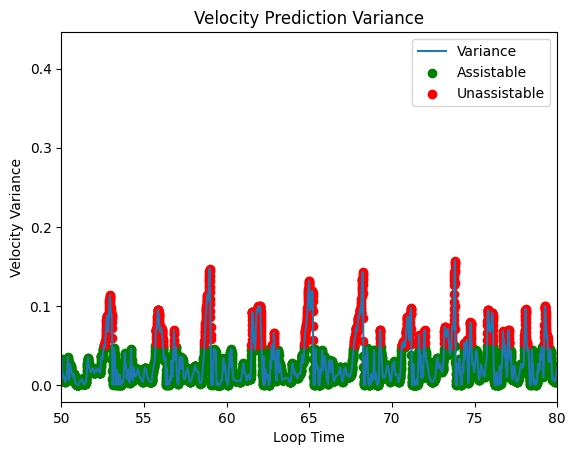

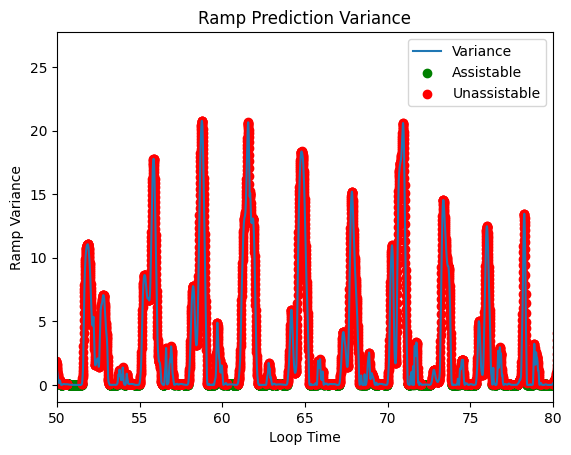

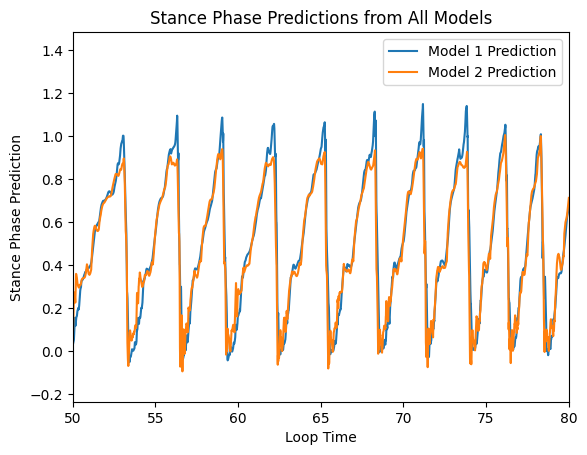

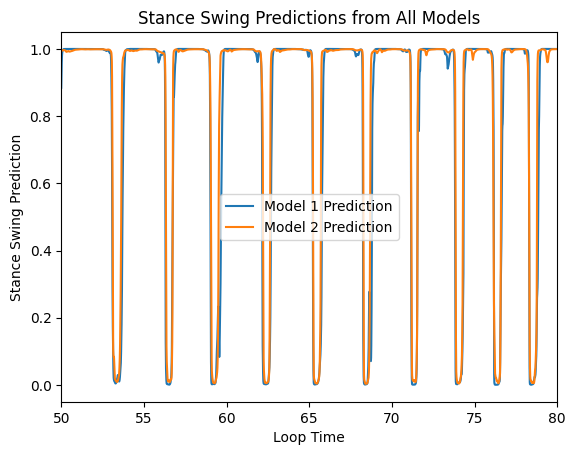

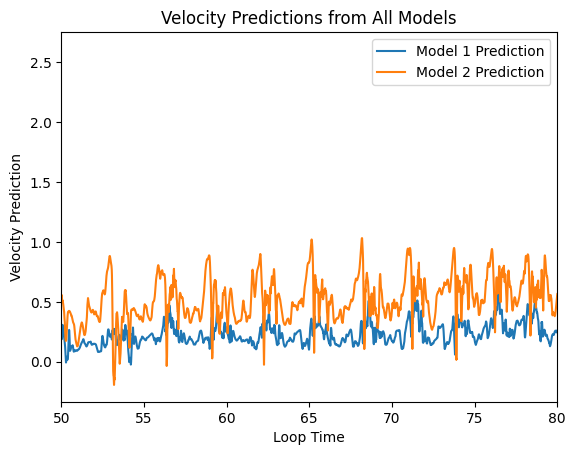

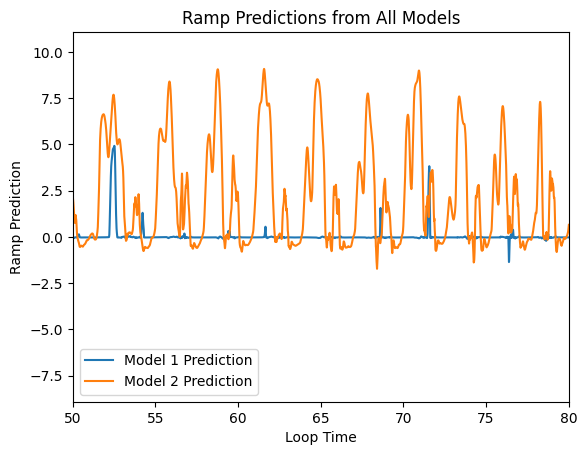

In [108]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ml_util_4_head
from tensorflow.keras.losses import MeanAbsoluteError

# Parameters
num_ensembles = 2
window_size = 80
num_channels = 8
threshold = 0.05

# Define the subjects, sides, and trials to test with
subjects_to_test_with = [10]
sides = ['LEFT']
trial_nums = np.array([1])
root_folder = "Fully_Processed_Dataset_with_all_the_4_variables"
print(root_folder)

files_to_test_with = ml_util_4_head.get_files_to_use(root_folder, subjects_to_test_with, sides, trial_nums)
print(files_to_test_with)

# Load ensemble models
models = []
for i in range(num_ensembles):
    model = create_model(window_size, num_channels, do_fix_input_dim)
    model.load_weights(f'ensemble_model_{i}.weights.h5')
    models.append(model)

# Initialize storage for results
training_instances = np.empty(shape=[0, window_size, num_channels], dtype=np.float32)

for myfile in files_to_test_with:
    data = ml_util_4_head.load_file(myfile)
    data2 = pd.read_csv(myfile)
    loop_time = data2['loop_time'].values[window_size-1:]
    x_test = tf.expand_dims(data[:, :num_channels], axis=0)
    x_test = tf.cast(x_test, dtype=tf.float32)
    y_sp_test = data[window_size-1:, -4]
    y_ss_test = data[window_size-1:, -3].astype(bool)
    y_v_test = data[window_size-1:, -1]
    y_r_test = data[window_size-1:, -2]

    # Collect predictions from each model
    model_predictions = [model.predict(x_test) for model in models]
    y_sp_preds = np.squeeze(np.stack([pred[0] for pred in model_predictions], axis=-1))
    y_ss_preds = np.squeeze(np.stack([pred[1] for pred in model_predictions], axis=-1))
    y_v_preds = np.squeeze(np.stack([pred[2] for pred in model_predictions], axis=-1))
    y_r_preds = np.squeeze(np.stack([pred[3] for pred in model_predictions], axis=-1))

    # Compute variances
    y_sp_var = np.var(y_sp_preds, axis=-1)
    y_ss_var = np.var(y_ss_preds, axis=-1)
    y_v_var = np.var(y_v_preds, axis=-1)
    y_r_var = np.var(y_r_preds, axis=-1)

    # Assess assistability
    y_sp_assistability = np.where(y_sp_var < threshold, 'assistable', 'unassistable')
    y_ss_assistability = np.where(y_ss_var < threshold, 'assistable', 'unassistable')
    y_v_assistability = np.where(y_v_var < threshold, 'assistable', 'unassistable')
    y_r_assistability = np.where(y_r_var < threshold, 'assistable', 'unassistable')

    # Plotting
    x_min = 50
    x_max = 80
    plt.figure()
    plt.plot(loop_time, y_sp_var, label='Variance')
    plt.scatter(loop_time[y_sp_assistability == 'assistable'], y_sp_var[y_sp_assistability == 'assistable'], color='green', label='Assistable')
    plt.scatter(loop_time[y_sp_assistability == 'unassistable'], y_sp_var[y_sp_assistability == 'unassistable'], color='red', label='Unassistable')
    plt.title('Stance Phase Prediction Variance')
    plt.xlabel('Loop Time')
    plt.ylabel('Stance Phase Variance')
    plt.xlim(x_min, x_max)
    plt.legend()

    plt.figure()
    plt.plot(loop_time, y_ss_var, label='Variance')
    plt.scatter(loop_time[y_ss_assistability == 'assistable'], y_ss_var[y_ss_assistability == 'assistable'], color='green', label='Assistable')
    plt.scatter(loop_time[y_ss_assistability == 'unassistable'], y_ss_var[y_ss_assistability == 'unassistable'], color='red', label='Unassistable')
    plt.title('Stance Swing Prediction Variance')
    plt.xlabel('Loop Time')
    plt.ylabel('Stance Swing Variance')
    plt.xlim(x_min, x_max)
    plt.legend()

    plt.figure()
    plt.plot(loop_time, y_v_var, label='Variance')
    plt.scatter(loop_time[y_v_assistability == 'assistable'], y_v_var[y_v_assistability == 'assistable'], color='green', label='Assistable')
    plt.scatter(loop_time[y_v_assistability == 'unassistable'], y_v_var[y_v_assistability == 'unassistable'], color='red', label='Unassistable')
    plt.title('Velocity Prediction Variance')
    plt.xlabel('Loop Time')
    plt.ylabel('Velocity Variance')
    plt.xlim(x_min, x_max)
    plt.legend()

    plt.figure()
    plt.plot(loop_time, y_r_var, label='Variance')
    plt.scatter(loop_time[y_r_assistability == 'assistable'], y_r_var[y_r_assistability == 'assistable'], color='green', label='Assistable')
    plt.scatter(loop_time[y_r_assistability == 'unassistable'], y_r_var[y_r_assistability == 'unassistable'], color='red', label='Unassistable')
    plt.title('Ramp Prediction Variance')
    plt.xlabel('Loop Time')
    plt.ylabel('Ramp Variance')
    plt.xlim(x_min, x_max)
    plt.legend()

        # Plotting predictions of each individual model for stance phase cos on the same plot
    plt.figure()
    for i in range(num_ensembles):
        plt.plot(loop_time, model_predictions[i][0].flatten(), label=f'Model {i+1} Prediction')
    plt.title('Stance Phase Predictions from All Models')
    plt.xlabel('Loop Time')
    plt.ylabel('Stance Phase Prediction')
    plt.xlim(x_min, x_max)
    plt.legend()
    plt.show()

    # Plotting predictions of each individual model for stance swing on the same plot
    plt.figure()
    for i in range(num_ensembles):
        plt.plot(loop_time, model_predictions[i][1].flatten(), label=f'Model {i+1} Prediction')
    plt.title('Stance Swing Predictions from All Models')
    plt.xlabel('Loop Time')
    plt.ylabel('Stance Swing Prediction')
    plt.xlim(x_min, x_max)
    plt.legend()
    plt.show()

    # Plotting predictions of each individual model for velocity on the same plot
    plt.figure()
    for i in range(num_ensembles):
        plt.plot(loop_time, model_predictions[i][2].flatten(), label=f'Model {i+1} Prediction')
    plt.title('Velocity Predictions from All Models')
    plt.xlabel('Loop Time')
    plt.ylabel('Velocity Prediction')
    plt.xlim(x_min, x_max)
    plt.legend()
    plt.show()

    # Plotting predictions of each individual model for ramp on the same plot
    plt.figure()
    for i in range(num_ensembles):
        plt.plot(loop_time, model_predictions[i][3].flatten(), label=f'Model {i+1} Prediction')
    plt.title('Ramp Predictions from All Models')
    plt.xlabel('Loop Time')
    plt.ylabel('Ramp Prediction')
    plt.xlim(x_min, x_max)
    plt.legend()
    plt.show()

    plt.show()


In [14]:
model.save('multi_head/og_test1.keras')

c:\Users\ft700\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model = tf.keras.models.load_model('multi_head/og_test1.keras', custom_objects={'custom_loss': custom_loss})

In [16]:
model.summary()
print(model.metrics_names)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 my_input_layer (InputLayer  [(None, None, 8)]            0         []                            
 )                                                                                                
                                                                                                  
 conv1d (Conv1D)             (None, None, 30)             4830      ['my_input_layer[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, None, 30)             120       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                              